#### • Chargement des différentes librairies

In [2]:
### • Chargement des différentes librairies

import sys, os #, math, time

sys.path.insert(0, os.path.dirname(os.getcwd()))

from src.thot.sesh import *
from src.thot.catch_features import *

# from scipy.fft import fft
import pywt, librosa            # type: ignore

import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn import model_selection, preprocessing as sk_p      # type: ignore
# Supervised learning
from sklearn import ensemble, svm, linear_model, neighbors      # type: ignore
# Unsupervised learning
from sklearn import discriminant_analysis

# from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier

# from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_validate # type: ignore
from sklearn.metrics import classification_report               # type: ignore

from keras.models import Sequential                             # type: ignore
from keras.callbacks import EarlyStopping                       # type: ignore
from keras.layers import GlobalAveragePooling1D, MaxPooling1D   # type: ignore
from keras.layers import ReLU, Dense, Dropout, Conv1D, Flatten  # type: ignore
# from keras.layers import LSTM, LeakyReLU, PReLU, ConvLSTM1D
# from keras.layers import Bidirectional, TimeDistributed, RepeatVector, Flatten

# import tensorflow as tf
# from tensorflow.keras.optimizers import AdamW, Adam            # type: ignore

# from pyriemann.spatialfilters import CSP

%matplotlib inline

#### • Déclaration de constantes

In [3]:
### • Déclaration de constantes

# Fréquence d'échantillonnage - Hz (Nombre de valeur / sec)
SAMPLE_RATE = 250
#
PW2 : int   = int(np.floor(np.log2(SAMPLE_RATE))) # 2 << SAMPLE_RATE // 32
#
NFFT : int  = 1 << PW2
# Epoque en sec donnée en nombre d'échantillon consectutif # 4" de données (multiple de 2)
CHUNK : int = ceil_pow2(SAMPLE_RATE) * 4 # SAMPLE_RATE << 1 # (1 << PW2) * 4
# Temps additionel pour étendre le domaines d'étude.
LAG : int   = 62 # 0 # CHUNK >> 2 # SAMPLE_RATE >> 2 #    # Décalage du signal dû signal ~250ms
# Taille des lots
BATCH : int = 32
#
SLIDE : bool = False

# Correspondance pour la classification
hands_event = {0: 'Left', 1: 'Right'}
# Nombre dévènement à prédire
numbers     = range(len(hands_event))
# Les bandes de fréquences d'intérêt
eeg_bands   = {'Delta' : (.1, 4),
               'Theta' : (4, 8),
               'Alpha' : (8, 14),
               'Beta'  : (14, 31),
               'Gamma' : (31, (SAMPLE_RATE >> 2) - 1),}
# Coefficients pour filtres Butterworth numérique d'ordre N pour le filtrage passe-bande
bands_coeff = {band : butter_bandpass(low, high, SAMPLE_RATE) for band, (low, high) in eeg_bands.items()}
# Largeur de bande retenue pour étude de cas
band_interest = butter_bandpass(1e-3, eeg_bands['Alpha'][1], SAMPLE_RATE)

LAG, CHUNK, (CHUNK if SLIDE else (CHUNK - LAG))  

(62, 1024, 962)

In [4]:
def catch(data : Board, col : str, channels : Clause, event : int,
            norm : bool = False) -> Board :
    func = [np.min, np.max, np.median]
    #, np.mean func = [np.min, np.max, np.std, np.var, np.mean, np.median]
    # func = np.append(func, catch_)
    room = data[data[col] == event]
    name = [f.__name__ for f in func]
    # head = [f"{f}_diff" for f in name]
    head = [f"{c}_{f}" for c in channels for f in name] \
         + [f"{f}_diff" for f in name]
    
    if norm :
        temp = [[normalized(x) for x in room[c]] for c in channels]
        c3, c4 = [[[f(v) for v in s] for f in func] for s in temp]
    else :
        c3, c4 = [[[f(v) for v in room[c]] for f in func] for c in channels]
    
    sub = np.subtract(c3, c4)
    _df = pd.DataFrame(np.array((*c3, *c4, *sub)).T, columns = head)
    # _df = pd.DataFrame(np.array(sub).T, columns = head)

    print(np.array((np.stack([c3, c4], axis= 1), *sub)))

    # display(_df)
    
    _df[col] = event
    
    return _df

def pool_(data : Board, event : int) -> Board :
    return catch(data, 'EventType', Gramm_DatasLoader.eeg_Chans[: -1], event, norm = True)

#### • Acquisition des données d'entrainement et de validation

In [5]:
# # Acquisition des données d'entrainement
path     = '../data/data.zip'
datas    = Gramm_DatasLoader(path, 'train', True)
files    = datas.files
entrants = datas.runs
targets  = datas.target

#### • Acquisition des données de test

In [ ]:
test_X = csv_in_zip(path, directory = 'test')

#### • Pré-traitement (Segmentation) des données

In [6]:
train_X, train_y, test_X, test_y = train_test_init(entrants, targets, files, methode = None)

Fichiers d'entrainements :
  B0103T.csv B0203T.csv B0303T.csv B0403T.csv B0503T.csv B0603T.csv B0703T.csv B0803T.csv B0903T.csv

Fichiers tests :
  B0101T.csv B0102T.csv B0201T.csv B0202T.csv B0301T.csv B0302T.csv B0401T.csv B0402T.csv B0501T.csv B0502T.csv B0601T.csv B0602T.csv B0701T.csv B0702T.csv B0801T.csv B0802T.csv B0901T.csv B0902T.csv



In [7]:
def foo_filter_01(data : Vector) -> Vector :
    b, a = bands_coeff['Delta']
    res  = [bandpass_filter(d[1] - d[0], b, a) for d in data]

    return np.array(res)

def foo_filter_02(data : Vector) -> Vector :
    b, a = bands_coeff['Delta']
    v1   = [np.append(bandpass_filter(d[0], b, a), bandpass_filter(d[1], b, a)) for d in data]
    
    return np.array(v1)

def foo_filter_03(data : Vector) -> Vector :
    b, a = bands_coeff['Delta']
    v1   = [np.append(bandpass_filter(d[1] - d[0], b, a), bandpass_filter(d[2], b, a)) for d in data]
    
    return np.array(v1)

def foo_psd(data : Vector) -> Vector :
    return None

def foo_concate(X) : return np.array([np.concatenate(x) for x in X])

#### • Test de classification - Proposition 01

In [12]:
# csp = CSP(nfilter = 2)
pca = PCA(CHUNK >> 4)
std = StandardScaler()
# std = RobustScaler()

#
clf = svm.SVC(gamma = 'scale', kernel = 'poly')
# 
rfc = ensemble.RandomForestClassifier(n_jobs = -1)
#
lrg = linear_model.LogisticRegression(solver = 'newton-cholesky')
#
dal = discriminant_analysis.LinearDiscriminantAnalysis()

chans = Gramm_DatasLoader.eeg_Chans + Gramm_DatasLoader.ecg_Chans # #
func  = foo_concate # foo_filter_01

# print(titre("Custome 'train_test_split'", 50))
# print(titre('train', 50))
# X_train, y_train = Gramm(train_X, train_y, chans, numbers, CHUNK, LAG,
#                          level = False, slide = SLIDE).shuffle(func)
# print(titre('test', 50))
# X_test, y_test   = Gramm(test_X, test_y, chans, numbers, CHUNK, LAG,
#                          level = False, slide = SLIDE).shuffle(func)
# print('-' * 50)

# 'saga' ''
# #
# knc = neighbors.KNeighborsClassifier() # .RadiusNeighborsRegressor()
# #
# lsg = linear_model.SGDClassifier()
# # 
# gbc = ensemble.GradientBoostingClassifier()
# # 
# nnp = MLPClassifier(solver = 'sgd', learning_rate = 'invscaling')
# # 
# kmn = cluster.KMeans(n_clusters = 2, algorithm='elkan')

# X_train_scaled = pca.fit_transform(X_train)
# X_test_scaled  = pca.transform(X_test) 

# X_train_scaled = X_train
# X_test_scaled  = X_test

In [13]:
sec   = SAMPLE_RATE << 2
lp    = 50
loc   = 0
table = np.zeros((sec // lp) ** 2, dtype = list)

for i in range(sec, lp << 1, -lp) :
    for j in range(0, min(i - lp, SAMPLE_RATE >> 0), lp) :
        print(titre(f'[{loc}] : {j}, {i}', 55))

        X_train, y_train = Gramm(test_X, test_y, chans, numbers, i, j,
                                 level = False, slide = SLIDE).shuffle(func)
        X_test, y_test   = Gramm(train_X, train_y, chans, numbers, i, j,
                                 level = False, slide = SLIDE).shuffle(func)
        X_train_scaled   = std.fit_transform(X_train)
        X_test_scaled    = std.transform(X_test)

        for reg in [clf, rfc] : # , lrg, dal
            scores : dict = cross_validate(reg, X_train_scaled, y_train, scoring = ['accuracy'])
            
            reg.fit(X_train_scaled, y_train)

            res   = scores['test_accuracy']
            score = reg.score(X_test_scaled, y_test)
            # pred  = reg.predict(X_test_scaled)

            table[loc] = [loc, j, i, score, res.mean(), res.max()]
            
            print(f"• {reg} :", *[f'{x:.1%}' for x in table[loc][3 :]])

            loc += 1
            # print(f"\tAccuracy -> {res.mean():.1%} (±{res.std():.2}, max : {res.max():.1%}) [Test-score : {score:.1%}]"), res.std(),

table = table[: loc]

# [x for x in table]

-------------------- [0] : 0, 1000 ---------------------
• SVC(kernel='poly') : 66.5% 52.3% 54.5%
• RandomForestClassifier(n_jobs=-1) : 67.3% 63.1% 65.8%
------------------- [2] : 50, 1000 ---------------------
• SVC(kernel='poly') : 68.8% 53.9% 59.4%
• RandomForestClassifier(n_jobs=-1) : 67.2% 63.5% 67.6%
------------------- [4] : 100, 1000 --------------------
• SVC(kernel='poly') : 67.2% 54.0% 58.7%
• RandomForestClassifier(n_jobs=-1) : 68.2% 62.7% 65.4%
------------------- [6] : 150, 1000 --------------------
• SVC(kernel='poly') : 66.0% 51.1% 54.5%
• RandomForestClassifier(n_jobs=-1) : 66.2% 58.1% 60.3%
------------------- [8] : 200, 1000 --------------------
• SVC(kernel='poly') : 63.1% 50.0% 52.0%
• RandomForestClassifier(n_jobs=-1) : 66.8% 59.8% 61.6%
-------------------- [10] : 0, 950 ---------------------
• SVC(kernel='poly') : 67.9% 53.8% 60.9%
• RandomForestClassifier(n_jobs=-1) : 68.5% 65.4% 69.2%
------------------- [12] : 50, 950 ---------------------
• SVC(kernel='poly'

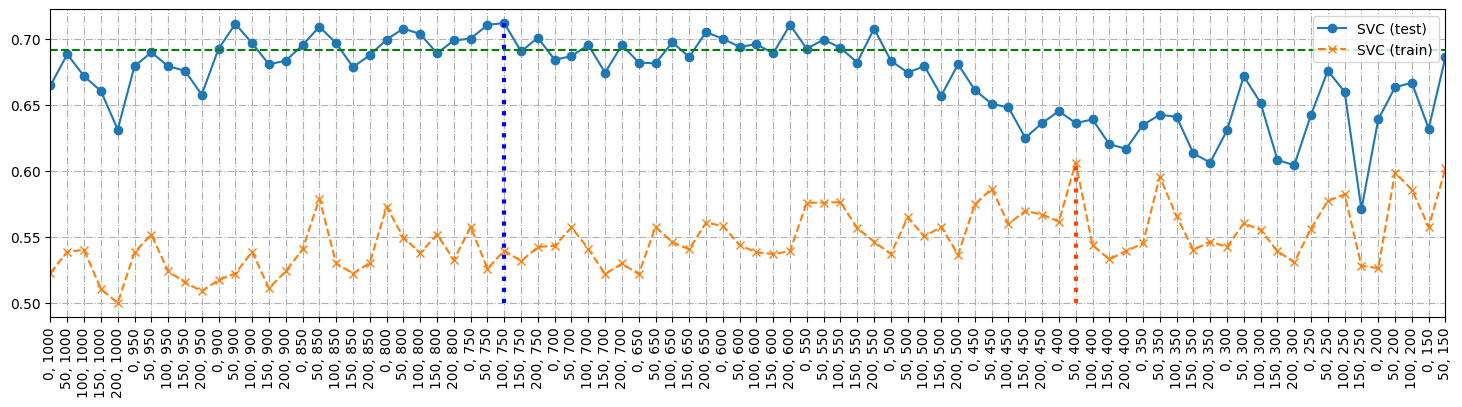

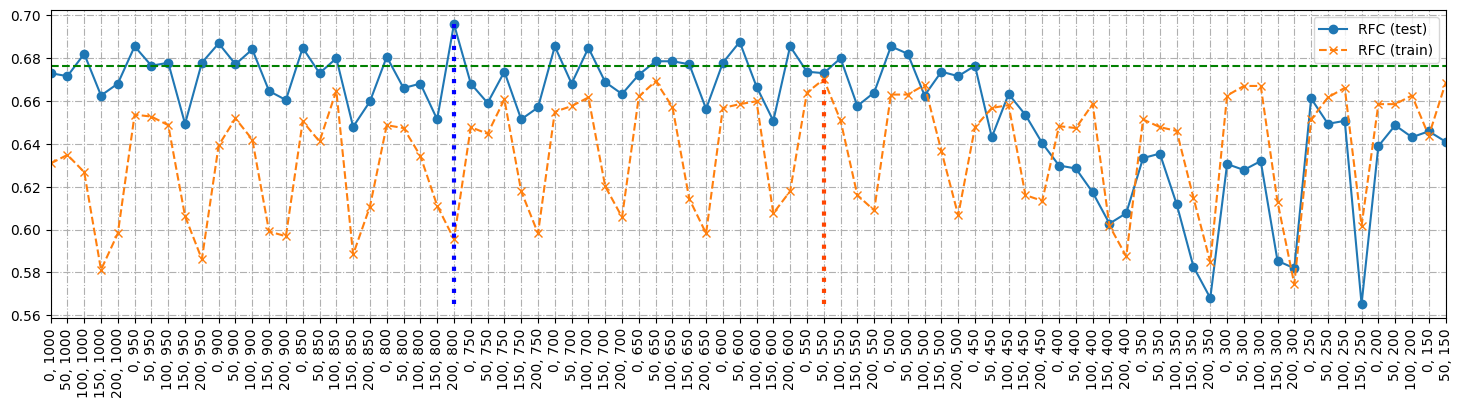

In [14]:
v1  = [list(table[i :: 2]) for i in range(2)]
pos = [f"{x[1]}, {x[2]}" for x in v1[0]]
leg = ['SVC', 'RFC']
xtk = range(loc >> 1)

for i in range(2) :
    curve_1 = np.array([float(x[3]) for x in v1[i]])
    curve_2 = np.array([float(x[4]) for x in v1[i]])
    max_1   = max(curve_1)
    max_2   = max(curve_2)
    up      = (max(np.mean(curve_1), np.mean(curve_2)) + max(max_1, max_2)) / 2

    x_1 = np.where(curve_1 == max_1)[0][0]
    x_2 = np.where(curve_2 == max_2)[0][0]
    org = min(min(curve_1), min(curve_2))

    plt.figure(figsize = (18, 4))

    view = plt.axes()

    # view.set_aspect('auto')
    # view.add_patch(plt.Circle((x_1, max_1), radius = .025, color = 'blue'))
    # view.add_patch(plt.Circle((x_2, max_2), radius = .025, color = 'orangered'))

    plt.xlim([xtk[0], xtk[-1]])
    plt.grid(visible = True, ls = '-.')
    plt.plot(xtk, curve_1, 'o-', label = f'{leg[i]} (test)')
    plt.plot(xtk, curve_2, 'x--', label = f'{leg[i]} (train)')
    plt.vlines(x_1, org, max_1, ls = ':', colors = 'blue', lw = 3)
    plt.vlines(x_2, org, max_2, ls = ':', colors = 'orangered', lw = 3)
    plt.hlines(up, 0, loc >> 1, colors = 'green', ls = '--')
    plt.xticks(xtk, labels = pos, rotation = 'vertical')
    plt.legend()
    plt.show();

In [ ]:
from sklearn.manifold import TSNE

tnse = TSNE(n_components = 2, learning_rate = 'auto')

X_embedded = tnse.fit_transform(X_train_scaled)

print(tnse.kl_divergence_, tnse.learning_rate_)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y_train)
plt.show()

# pd.crosstab(X_embedded[:, 0].T, y_train), random_state = 42

https://raphaelvallat.com/bandpower.html

#### • Test EEG Torch

In [ ]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets            # type: ignore
from torchvision.transforms import ToTensor # type: ignore

torch.cuda.is_available()

In [ ]:
# https://www.kaggle.com/code/banggiangle/cnn-eeg-pytorch

class EEG_Dataset(Dataset) :
    def __init__(self, datas : list[Board], labels : list[Board] | None, Channels : Clause,
                 events : int | Index, chunk_size : int, gap : int, transform = None) :
        self.transform  = transform
        self.parts      = torch_split(datas, labels, Channels, events, chunk_size, gap)
        self.len        = len(self.parts)
        # self.X          = datas
        # self.y          = labels
        # self.Channels   = Channels
        # self.events     = events
        # self.chunk_size = chunk_size
        # self.gap        = gap
        
    def __getitem__(self, index : int) :
            source_ = self.parts[index]

            if self.transform is not None : source_ = self.transform(source_)
            
            return source_, torch.tensor((index << 1) // self.len)

    def __len__(self) : return self.len

class EEG_RNN(nn.Module) :
    def __init__(self, input_size : int, hidden_size : int, output_size : int) :
        super(EEG_RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first = True)
        self.fc  = nn.Linear(hidden_size, output_size)
    
    def forward(self, x) :
        h0      = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _  = self.rnn(x, h0)
        out     = self.fc(out)
        
        return out

In [ ]:
train_parts = Gramm(train_X, train_y, Gramm_DatasLoader.eeg_Chans, numbers, CHUNK, LAG)
test_parts  = Gramm(test_X, test_y, Gramm_DatasLoader.eeg_Chans, numbers, CHUNK, LAG)

train_loader = DataLoader(train_parts, batch_size = BATCH, shuffle = True)
test_loader  = DataLoader(test_parts, batch_size = BATCH, shuffle = True)

print(titre("Custome 'train_test_split'", 40))
print('Torseur train\t:', *train_parts.parts.shape)
print('Torseur test\t:', *test_parts.parts.shape)
print('-' * 40)

# X, y = next(iter(train_loader))
# X, y = next(iter(DataLoader(train_parts, batch_size = BATCH, shuffle = True)))

device = "cpu"

model = nn.Sequential(
   nn.Conv2d(in_channels = BATCH, out_channels = BATCH >> 1, kernel_size = 3),
   nn.MaxPool2d(kernel_size = 2),
   nn.ReLU(),
    
   nn.Conv2d(in_channels = 512 >> 1, out_channels = 512 >> 2, kernel_size = 3),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size = 2),
    
   nn.Conv2d(in_channels = 512 >> 2, out_channels = 512 >> 3, kernel_size = 3),
   nn.ReLU(),
   nn.MaxPool2d(kernel_size = 2),
    
   nn.Flatten(),
#    nn.Linear(64 * 6 * 6, 64),
   nn.ReLU(),
   nn.Linear(512 >> 3, 4)
)

model.to(device)

# criterion  = nn.RNN((3, 512), hidden_dim, layer_dim, batch_first = True, nonlinearity = 'relu') # nn.CrossEntropyLoss()
# preprocess = weights.transforms()
# y_pred     = model(X.to(device))

# criterion(y_pred, y.to(device))

In [ ]:
from tqdm.notebook import tqdm

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

# Training loop
num_epochs = 10

for epoch in range(num_epochs) :
    model.train()

    # outputs = model(X.unsqueeze(2))  # Add a dimension for input size
    # loss    = criterion(outputs, y.unsqueeze(2))
    
    loss_total   = 0
    progress_bar = tqdm(train_loader, desc = f"Epoch {epoch:1d}",
                        leave = True, disable = False)
    
    for i, batch in enumerate(progress_bar) :
        # Batch de données
        X_batch, y_batch = batch
        # Device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Gradient mis 0
        model.zero_grad()

        # Calcul de prédiction
        y_pred = model(X_batch.to(torch.float32))

        # Calcul de la fonction de perte
        loss =  criterion(y_pred, y_batch) 
        # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
        loss.backward()
        
        # Clipper le gradient entre 0 et 1 pour plus de stabilité
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Descente de gradient : actualisation des paramètres
        optimizer.step()
        
        loss_total += loss.item()
        
        progress_bar.set_postfix({"training_loss": "{:.3f}".format(loss_total / (i + 1))})
    
    # if (epoch + 1) % 10 == 0 :
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

#### • Test prédiction

In [ ]:
### • Visualisation des spectrogrammes / Test

def logMelSpectrogram(data : Vector, rate : int, dt : float = 1e-2) -> Vector :
    tps = 1 << int(np.floor(np.log2(rate * dt)))
    # print(tps)
    # Spectrogramme
    stfts = np.abs(librosa.stft(y = data, n_fft = tps, hop_length = 1 << 2, center = True)).T
    # Filtre de MEL
    liny  = librosa.filters.mel(sr = rate, n_fft = tps + 1, n_mels = stfts.shape[-1]).T
    # Application du filtre au spectrogramme
    mel_  = np.tensordot(stfts, liny, 1)

    return np.log(mel_ + 1e-6)
    
def structure(data : Board | Vector, rate : int, whr : Clause) -> Vector :
    # return np.array([logMelSpectrogram(X, rate, 2) for X in data[whr]])
    # return np.stack([[signal.welch(X, rate)[1] for X in data[c]] for c in whr], axis = 2)
    return np.stack(data['C4'] - data['C3'], axis = 0)
    # return np.stack([[X for X in data[c]] for c in whr], axis = 2)

def img_spectrogram(raw : Vector, rate : int, nfft : int = 1 << 10) -> Vector :
    return librosa.feature.melspectrogram(y = raw, sr = rate, hop_length = 1, 
                            n_fft = nfft, n_mels = 32, fmin = 0, fmax = 20, win_length = 32)

def spectrogram_dep(data : Board, rate : int, channels : Clause, n_row : int = 5, n_col : int = 12) :
    sample = np.random.default_rng().integers(data.shape[0], size = n_row)

    sample.sort()

    plt.figure(figsize = (18, 2 * .48 * n_row))

    pos = 0

    for k in sample :
        for c in channels :
            # x   = normalized(data[c][k])
            raw = img_spectrogram(raw = data[c][k], rate = rate)
            pos += 1
            
            plt.subplot(n_row, n_col, pos)
            plt.title(f"{((pos - 1) // 3) + 1} . {k} - {c}", fontsize = 8)
            librosa.display.specshow(data = 1 - raw, sr = rate, hop_length = 1)
            
            # pos = n_col * (i >> 1) + j
            # f, t, Sxx = signal.spectrogram(x, rate)
            # plt.subplot(n_row, n_col, pos + 4)
            # plt.pcolormesh(t, f, 1 - Sxx, shading = 'gouraud')

    plt.tight_layout()
    plt.show();

def spectrogram(data : Board, rate : int, channels : Clause, n_row : int = 5, n_col : int = 12) :
    sample = np.random.default_rng().integers(data.shape[0], size = n_row)

    sample.sort()

    plt.figure(figsize = (18, 2 * .48 * n_row))

    freq = np.arange(1, rate >> 1)
    pos  = 0
    # extd = np.append([0, 1, 1], freq[-1])
    
    for k in sample :
        for c in channels :
            pos += 1
            x   = normalized(data[c][k])
            coefficients, _ = pywt.cwt(x, scales = freq, wavelet = 'cmor')

            plt.subplot(n_row, n_col, pos)
            plt.imshow(np.abs(coefficients), aspect = 'auto', cmap = 'jet') #, extent = extd
            # plt.colorbar(label="Magnitude")
            # plt.ylabel("Scale")
            # plt.xlabel("Time")
            # plt.title("CWT of a Chirp Signal")
            plt.axis('off')

    plt.show()

def plot_logMelSpectrogram(data, rate) :
    sns.heatmap(np.rot90(logMelSpectrogram(data, rate)), cmap = 'inferno')
    
    # loc, _ = plt.xticks()
    # l      = np.round((loc - loc.min()) * len(data) / fe / loc.max(), 2), vmin = -6

    # plt.xticks(loc, l)
    plt.yticks([])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Mel)")

In [ ]:
H = [list(harmonic(x, bands_coeff).values()) for x in [df_train[c] for c in eeg_Chans]]

np.shape(H), np.shape(np.stack(np.stack(H, axis = 1), axis = 2)), np.shape(H[0][1][0])
# harmonic(trains['C3'][256], bands_coeff).values())), H

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns = ['EventType']),
                                                    df_train['EventType'], test_size = .2, random_state = 42)

# X_train, X_test, y_train, y_test = train_test_split([v.tolist() for v in np.array(trains[eeg_Channels])],
#                                                     trains['EventType'], test_size = .2, random_state = 42)

In [ ]:
# train_dataset = np.array(X_train)
# test_dataset  = X_test

# train_dataset = structure(X_train, SAMPLE_RATE, eeg_Chans[:2])
# test_dataset  = structure(X_test, SAMPLE_RATE, eeg_Chans[:2])

# train_dataset = structure(X_train, SAMPLE_RATE, eeg_Chans[: 2])
# test_dataset  = structure(X_test, SAMPLE_RATE, eeg_Chans[: 2])

train_dataset = structure(df_train.drop(columns = ['EventType']), SAMPLE_RATE, eeg_Chans[: 2])
test_dataset  = structure(df_test.drop(columns = ['EventType']), SAMPLE_RATE, eeg_Chans[: 2])

# print(train_dataset.shape)

In [ ]:
#### • Test prédiction

# UNITS     : int   = 100
BATCHSIZE : int   = 32
EPOCH     : int   = 1000
ZERO      : int   = 32
DROPOUT   : float = 1 / 4

OPTIMIZER = 'AdamW'     # adamax, , adafactor, adam, nadam
# kl_divergence mean_squared_logarithmic_error mean_absolute_error
LOSS      = 'sparse_categorical_crossentropy'
ACTIV     = ReLU   # PReLU, LeakyReLU
K_SIZE    = (5)

model = Sequential([
    # - Couche 1 -
    Conv1D(filters = ZERO, kernel_size = K_SIZE, dilation_rate = 2,
           input_shape = train_dataset.shape),
    ACTIV(),
    MaxPooling1D(pool_size = 2, strides = 1),
    Dropout(rate = DROPOUT),
    # - Couche 2 -
    Conv1D(filters = ZERO << 1, kernel_size = K_SIZE, dilation_rate = 2),
    ACTIV(),
    MaxPooling1D(pool_size = 2, strides = 1),
    Dropout(rate = DROPOUT),
    # - Couche 3 -
    Conv1D(filters = ZERO << 2, kernel_size = K_SIZE, dilation_rate = 2),
    ACTIV(),
    MaxPooling1D(pool_size = 2, strides = 1),
    Dropout(rate = DROPOUT),
    # - Flatten layer -
    Flatten(),
    GlobalAveragePooling1D(),
    # - Couches de sortie -
    Dense(units = ZERO << 2),
    ACTIV(),
    Dropout(rate = DROPOUT),
    Dense(units = len(hands_event), activation = 'softmax'), # sigmoid 
])

model.summary()
model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = ['acc'])

print()

stop    = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 50)
history = model.fit(train_dataset, y_train, validation_data = (test_dataset, y_test), verbose = 1,
                    batch_size = BATCHSIZE, epochs = EPOCH, callbacks = [stop])

In [ ]:
pred = model.predict(test_dataset)

sum([np.where(x > .5)[0][0] for x in pred] == y_test) / len(pred)

In [ ]:
history_dict = history.history
loss_values  = history_dict['loss']
acc_values   = history_dict['accuracy']
absc         = range(1, len(loss_values) + 1)

plt.figure(figsize = (12, 4))

plt.subplot(121)
plt.plot(absc, loss_values, label = 'Loss')
plt.plot(absc, acc_values, label = 'Accuracy')
plt.title('Training')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(122)
plt.plot(absc, history_dict['val_loss'], label = 'Loss')
plt.plot(absc, history_dict['val_accuracy'], label = 'Accuracy')
plt.title('Testing')
plt.xlabel('Epochs')
plt.legend()
plt.show();

#### • Visualisation densité spectrale du Signal

In [ ]:
### • Visualisation Densité Spectral du Signal

plot_psd(entrants, train_runs, rate = SAMPLE_RATE, Channels = eeg_Chans, titled = headers)

#### • Densité spectrale / échantillon

In [ ]:
### • Densité spectral / échantillon

inc   = 40
scp = samples(train_samples, inc)
boolInt = -2

plt.figure(figsize = (15, inc * 1.5))

for i in scp :
    boolInt += 2

    for c in eeg_Chans :
        target = train_runs[0][c][i]
        yest, Pxx_den = signal.welch(target, SAMPLE_RATE)   # , scaling = 'spectrum'
        
        plt.subplot(inc, 4, boolInt + 1)
        plt.semilogy(yest, Pxx_den, label = c)
        plt.title(f"welch - {i + 1}", fontsize = 11)
        plt.grid()

        plt.subplot(inc, 4, boolInt + 2)
        res, _ = plt.psd(target, Fs = SAMPLE_RATE, label = c) # , NFFT = NFFT
        plt.title(f"psd - {i + 1}", fontsize = 11)
        plt.xlabel('')
        plt.ylabel('')
        # plt.legend()

plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
plt.tight_layout()
plt.show();

# f, Pxx_den = signal.welch(train_eras[0]['C3'][752], SAMPLE_RATE)

# print(len(Pxx_den))

#### • Visualisation Epoques

In [ ]:
### • Visualisation Epoques

for i in range(len(files))[:: 3] :
    plot_signal(entrants[i], parts[i], train_spots[0][i], train_spots[1][i], channels = eeg_Chans, # 
                period = CHUNK, lag = LAG, title = headers[i])

#### • Visualisation décomposition des signaux

In [ ]:
### • Visualisation Décomposition des signaux

# Test de décomposition des signaux en bandes de fréquences spécifiques compatibles avec les répartitions usuelles
# dans le domaine des EEG ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

for input, token in zip(train_runs, ['Gauche', 'Droite']) :
    print(f"Exemples - Évènement Discriminé Main {token}")
    plot_wavelets(input, bands_coeff, eeg_Chans, scope = 30, headers = headers)

#### • Visualisation des spectrogrammes (test)

In [ ]:
for i, t in zip(numbers, ['Gauche', 'Droite']) :
    print(f"Exemples - Évènement Discriminé Main {t}")
    spectrogram(train_runs[i], SAMPLE_RATE, eeg_Chans, 32)

#### • MNE époque (test)

In [ ]:
### • MNE époque (test)

raw_csv = entrants[0][eeg_Chans]
info    = mne.create_info(ch_names = eeg_Chans, sfreq = SAMPLE_RATE, ch_types = 'eeg')
raw_mne = mne.io.RawArray(raw_csv.T * 1e-6, info)
sites     = np.where(entrants[0]['EventStart'] == 1)[0]

# display(compare(np.sort(np.concatenate((train_spots[0][0], train_spots[1][0]))), loc))

tmin, tmax = -0., 1

# loc = mne.find_events(raw_mne, stim_channel = 'C3')
# event_id = dict(C3 = 1, aud_r = 2, vis_l = 3, vis_r = 4)
# raw = mne.io.Raw(raw_mne, preload = True)
# raw.filter(2, None, method = 'iir')           # replace baselining with high-pass
# events = mne.read_events(event_fname)

# raw.info['bads'] = ['MEG 2443']  # set bad channels
# picks = mne.pick_types(info, meg = 'grad', eeg = True, eog = False, exclude = 'bads')
# Read epochs
absc = mne.Epochs(raw_mne, np.array([sites, sites, sites]).T, None, tmin, tmax, proj = False,
                    picks = None, baseline = None, preload = True, verbose = False) # event_id picks

# labels = epochs.events[::5, -1]

# events

# raw_mne.plot();

# raw_mne['C3'][0][0], len(df_train_csv[2]['Cz'])

display(absc)

#### • Test de classification - Proposition 02

In [ ]:
b, target = bands_coeff['Theta']

i = np.random.randint(np.shape(X)[0])
target = df_train['C4'][i] - df_train['C3'][i]
# X = [np.sign(s) for s in (trains['C4'] - trains['C3'])]
# y = {band: bandpass_filter(X[i], b, a) for band, (b, a) in bands_coeff.items()}

plt.figure()
# plt.style.use('')

plt.plot(normalized(bandpass_filter(target, b, target)), label = 'C4 - C3')
plt.plot(normalized(bandpass_filter(np.sign(target), b, target)), label = '[C4 - C3]', c = np.random.rand(1, 3)[0])
# plt.plot(pywt.dwt(y, wavelet = 'db4')[0], label = 'C4 - C3')
# plt.plot(pywt.dwt(np.sign(y), wavelet = 'db4')[0], label = '[C4 - C3]')
# plt.plot(np.zeros(512), ls = '--', c = np.random.rand(1, 3)[0])

# print(np.shape(pywt.dwt(y, wavelet = 'db8')))

# plt.plot(bandpass_filter(np.sign(trains['C3'][i]), b, a), label = 'C3')
# plt.plot(bandpass_filter(np.sign(trains['C4'][i]), b, a), label = 'C4')
# plt.plot(bandpass_filter(np.sign(trains['Cz'][i]), b, a), label = 'Cz')

# for (band, signal) in reversed(y.items()) :
#     plt.plot(pd.Series(signal), label = f'{band}', c = np.random.rand(1, 3)[0])

plt.title(f"{i}")
plt.legend(loc = 'upper right')

plt.grid()
plt.tight_layout()
plt.show();

In [ ]:
params = {
    ## K-plus proches voisins
    'knn__n_neighbors' : range(2),
    ## SVM
    'svm__C'      : [0.1, 1, 5],
    'svm__kernel' : ['linear', 'softmax', 'sigmoid', 'rbf'],
    ## RandomForest
    # 'rf__max_features'      : ['sqrt', 'log2', None],
    # 'rf__min_samples_split' : range(2, 32, 2),
    # , ('rf', clf3), ('rf', clf3)
    'estimators': [[('knn', knc), ('svm', svm)], [('knn', knc), ('svm', svm)]] 
    }

grid = model_selection.GridSearchCV(estimator = Voting_clf, param_grid = params, cv = 5) \
    .fit(X_train_scaled, y_train)

# parametres = {'max_features' : ['log2', 'sqrt', None], 'min_samples_split' : range(2, 32, 2)}

# vclf = model_selection.GridSearchCV(estimator = clf3, param_grid = parametres, cv = 3) \
#     .fit(X_train_scaled, y_train)

print(grid.best_estimator_)
print(grid.best_score_)
print('score train :', grid.score(X_train_scaled, y_train))
print('score test :', grid.score(X_test_scaled, y_test))

# print(vclf.best_estimator_, vclf.best_params_, vclf.best_score_)
# print('score train :', grid.score(X_train_scaled, y_train), vclf.score(X_train_scaled, y_train))
# print('score test  :', grid.score(X_test_scaled, y_test), vclf.score(X_test_scaled, y_test))

df_train_cpy, event_start = fancy_df(entrants, targets['EventType'], hands_event, CHUNK)

fig, axes = plt.subplots(1, 1, figsize = (24, 5), sharey = True)
sig = .05

axes.plot(entrants['C3'])

for p in event_start :
    axes.axvspan(p[0] - (CHUNK >> 1), p[0] + 1.5 * CHUNK, facecolor = 'orangered', alpha = .5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Score')

In [ ]:
boolInt = 16
start   = event_start[boolInt][0]
entrant = start + CHUNK
input   = df_train_cpy['C3_4'][start : entrant]
smooth  = input.copy()
inc     = 5
alpha   = 1 / 3
dec     = int(inc / alpha)

plt.figure(figsize = (24, 5))
plot_window(entrants, ['C3', 'C4', 'C3 + C4'], start, CHUNK)

# Lissage des hautes fréquences
for _ in range(inc) :
    smooth = simple_exponential_smoothing(smooth, alpha, 0)

smooth = pd.Series(index = range(start, entrant + inc - dec), data = smooth[dec :])

# plt.plot(raw - smooth, label = hands[event_start[pos][1]])
plt.plot(smooth, '--', label = hands_event[event_start[boolInt][1]])
plt.legend()
plt.show()

#### • Apendix

<h2 style = "text-align:center" ><b>EEG</b> - Prédiction des Mouvements Imaginaires de la Main</h2>

---

#### **1. Le projet**
- Intoduction  
https://github.com/DataScientest-Studio/mar24_cds_eeg/blob/eric/references/Description_projet_EEG.pdf  
https://www.bbci.de/competition/iv/desc_2b.pdf
- Ressources / Données   
https://www.kaggle.com/competitions/ucsd-neural-data-challenge/overview  
- Bibliographie  
https://www.bbci.de/competition/iv/desc_2b.pdf
#### **2. Liens utils**
- SciPy - *open-source software for mathematics, science, and engineering*  
https://docs.scipy.org/doc/scipy/index.html  
https://docs.scipy.org/doc/scipy/reference/signal.html  
- MNE - *MEG + EEG Analysis & Visualisation*
   - Accueil  
   https://mne.tools/stable/index.html

   - MNE - Data structures from arbitrary data  
   https://mne.tools/stable/auto_tutorials/io/10_reading_meg_data.html#creating-mne-data-structures-from-arbitrary-data-from-memory
   
   - MNE - EEG Preprocessing  
   https://mne.tools/dev/auto_tutorials/preprocessing/index.html  

- pyRiemann - *Biosignals classification with Riemannian geometry*  
https://pyriemann.readthedocs.io/en/latest/  
- neurodsp - *Neuro Digital Signal Processing Toolbox*  
https://neurodsp-tools.github.io/neurodsp/index.html#
- Rythme Mu  
https://fr.wikipedia.org/wiki/Rythme_Mu
- Spectrogram from EEG  
https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg
- Divers  
https://signalprocessingsociety.org/  
https://fr.wikipedia.org/wiki/Filtre_de_Butterworth  
https://fr.wikipedia.org/wiki/Moyenne_mobile  
https://terpconnect.umd.edu/~toh/spectrum/Differentiation.html  
https://perso.etis-lab.fr/ghaffari/2014_CCMB_Floride_USA.pdf  
https://www.youtube.com/watch?v=wB417SAbdak&list=PLXc9qfVbMMN2TAoLHVW5NvNmJtwiHurzw  
https://fastercapital.com/fr/sujet/identification-des-artefacts-de-traitement-du-signal-dans-des-sc%C3%A9narios-r%C3%A9els.html#:~:text=L'inspection%20visuelle%20est%20la,des%20pertes%20et%20du%20bruit.  
   - Z-Score Normalisation  
   https://fr.wikipedia.org/wiki/Cote_Z_(statistiques)  
   https://typeset.io/questions/why-is-z-score-normalisation-necessary-in-pre-processing-eeg-1xv5jepyq5  

   - Traitement numérique du signal  
   https://fr.wikipedia.org/wiki/Traitement_num%C3%A9rique_du_signal  
   - Ondelette  
      - Wiki  
      https://fr.wikipedia.org/wiki/Ondelette  

      - L’analyse par ondelettes dans la vie de tous les jours  
      https://interstices.info/lanalyse-par-ondelettes-dans-la-vie-de-tous-les-jours/  

      - A guide for using the Wavelet Transform in Machine Learning  
      https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
      
      - pyWavelets - *open source wavelet transform*  
      https://pywavelets.readthedocs.io/en/latest/

      - Ondelettes et applications  
      https://www.i2m.univ-amu.fr/~caroline.chaux/GEOMDATA/TI-te5215.pdf

   - Maximum de vraisemblance  
   https://pmarchand1.github.io/ECL8202/notes_cours/03-Maximum_vraisemblance.html  
   https://fr.wikipedia.org/wiki/Maximum_de_vraisemblance#:~:text=En%20statistique%2C%20l'estimateur%20du,maximisant%20la%20fonction%20de%20vraisemblance  

   - Transformation de Fourier discrète  
   https://fr.wikipedia.org/wiki/Transformation_de_Fourier_discr%C3%A8te  
      - La Transformation de Fourier n’est pas adaptée à l’analyse des signaux non stationnaires.
   - Neural Data Science in Python  
   https://neuraldatascience.io/intro.html

   - Preprocessing of EEG  
   https://www.frontiersin.org/articles/10.3389/fninf.2015.00016/full#:~:text=The%20depositable%20preprocessing%20pipeline%20consists,with%20a%20low%20recording%20SNR  
   https://typeset.io/papers/preprocessing-of-eeg-4go8vhcbty  
   https://learn.neurotechedu.com/preprocessing  
   https://g0rella.github.io/gorella_mwn/preprocessing_eeg.html  
   
   - Biblio :  
   https://perso.telecom-paristech.fr/bloch/P6Image/ondelettestrsp.pdf  
   https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/ondelettesIMAT.pdf  
   http://w3.cran.univ-lorraine.fr/perso/radu.ranta/pdf/cours_deb_ond%28fr%29.pdf
   
   - Digital Filtering  
   http://notebooks.pluxbiosignals.com/notebooks/Categories/Pre-Process/digital_filtering_eeg_rev.html

   - Processus stationnaire  
   https://fr.wikipedia.org/wiki/Processus_stationnaire

   - Analyse en composantes principales  
   https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales#:~:text=L'ACP%2C%20d%C3%A9sign%C3%A9e%20en%20g%C3%A9n%C3%A9ral,une%20grandeur%20physique%2C%20comme%20les